# Radiology report NLP

This notebook demonstrated how to use the functions in the `nlprules` module to extract structured information from radiology reports.
by Lewis Howell

In [1]:
# Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from nlprules.preprocessing import clean_dataframe, remove_stopwords, remove_negated_phrases
from nlprules.radexpressions import evaluate_regex, get_regex_proximity, get_regex_wildcards, string_search
from nlprules.dfsearch import check_all_matches, search_dataframe, evaluate_sentences, list_to_string
from nlprules.expression import Expression

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'pandas'

## Data loading and cleaning

- Load the data 
- Clean the data by removing punctuation and making all text lowercase
- Remove stopwords (optionally) which are words that do not add much meaning to the text

In [2]:
# Read in the data
file_path = 'data/synthetic_ultrasound_reports/ex_usreports_testing.csv'
df_data0 = pd.read_csv(file_path)
df_data0.fillna('', inplace=True)

# Display the first 5 rows
with pd.option_context('display.max_colwidth', None):
    display(df_data0.head())
    
len(df_data0)

,report,label
0,"The ultrasound of the thyroid gland reveals a solitary hypoechoic nodule measuring 1.4 cm in the right lobe, with irregular margins and increased internal vascularity. Additionally, diffuse heterogeneous echotexture is noted in the surrounding thyroid tissue.",thy nodule thyroiditis
1,"Ultrasound evaluation of the thyroid gland demonstrates multiple nodules bilaterally. The largest nodule, measuring 1.8 cm in the left lobe, displays a hypoechoic appearance with microcalcifications. The right lobe appears normal, with no significant abnormalities detected.",thy nodule nodules
2,"The thyroid gland appears diffusely enlarged with heterogeneous echotexture. Increased vascularity is observed on Doppler imaging, suggesting a possible inflammatory process such as thyroiditis.",thy goitre thyroiditis
3,Ultrasound examination of the thyroid gland reveals a goitre characterized by diffuse enlargement of the gland without discrete nodules. The echotexture appears heterogeneous with no significant vascularity detected.,thy goitre thyroiditis
4,"The patient has a history of prior thyroid surgery. Ultrasound evaluation demonstrates postsurgical changes with absence of the thyroid gland in the left lobe and isthmus, while the right lobe appears normal in size and echotexture.",thy surgery


60

In [3]:
# Set variables for the columns
column_report = 'report'
column_history = 'history'
column_label = 'label'

# Negex
The negex algorithm uses regular expressions to handle negation in text - Chapman et al. (2001)


In [4]:
phrase = 'Ultrasound of the thyroid gland shows \
        no observed nodules or other abnormalities in the right lobe \
        but several small nodules in the left lobe.'

remove_negated_phrases(phrase, rules=None, drop_ambiguous=True, replace_connectors=False, verbose=True)


Ultrasound of the thyroid gland shows [PREN]no[PREN] observed nodules or other abnormalities in the right lobe [CONJ]but[CONJ] several small nodules in the left lobe



'Ultrasound of the thyroid gland shows but several small nodules in the left lobe'

In [5]:
# Clean the data
df_data = clean_dataframe(df_data0, [column_report], 
                          drop_duplicates=True, # drop duplicate entries
                          drop_nulls=True, # drop empty reports
                          drop_negatives=True, # remove negated phrases
                          drop_ambiguous=True # remove phrases with ambiguous negation
                          ) 
# df_data = clean_dataframe(df_data, [column_label], 
#                           drop_duplicates=False, drop_nulls=True, drop_negatives=False) # This removes punctuation and makes all text lowercase

df_data['report0'] = df_data0['report']
with pd.option_context('display.max_colwidth', None):
    display(df_data[['report0', 'report', 'label']].head())

,report0,report,label
0,"The ultrasound of the thyroid gland reveals a solitary hypoechoic nodule measuring 1.4 cm in the right lobe, with irregular margins and increased internal vascularity. Additionally, diffuse heterogeneous echotexture is noted in the surrounding thyroid tissue.",the ultrasound of the thyroid gland reveals a solitary hypoechoic nodule measuring 1.4 cm in the right lobe with irregular margins and increased internal vascularity. additionally diffuse heterogeneous echotexture is noted in the surrounding thyroid tissue,thy nodule thyroiditis
1,"Ultrasound evaluation of the thyroid gland demonstrates multiple nodules bilaterally. The largest nodule, measuring 1.8 cm in the left lobe, displays a hypoechoic appearance with microcalcifications. The right lobe appears normal, with no significant abnormalities detected.",ultrasound evaluation of the thyroid gland demonstrates multiple nodules bilaterally. the largest nodule measuring 1.8 cm in the left lobe displays a hypoechoic appearance with microcalcifications. the right lobe appears normal with,thy nodule nodules
2,"The thyroid gland appears diffusely enlarged with heterogeneous echotexture. Increased vascularity is observed on Doppler imaging, suggesting a possible inflammatory process such as thyroiditis.",the thyroid gland appears diffusely enlarged with heterogeneous echotexture. increased vascularity is observed on doppler imaging suggesting a possible inflammatory process such as thyroiditis,thy goitre thyroiditis
3,Ultrasound examination of the thyroid gland reveals a goitre characterized by diffuse enlargement of the gland without discrete nodules. The echotexture appears heterogeneous with no significant vascularity detected.,ultrasound examination of the thyroid gland reveals a goitre characterized by diffuse enlargement of the gland. the echotexture appears heterogeneous with,thy goitre thyroiditis
4,"The patient has a history of prior thyroid surgery. Ultrasound evaluation demonstrates postsurgical changes with absence of the thyroid gland in the left lobe and isthmus, while the right lobe appears normal in size and echotexture.",the patient has a history of prior thyroid surgery. ultrasound evaluation demonstrates postsurgical changes with,thy surgery


In [6]:
# Remove stopwords (by default, this uses nltk stopwords)
stop_words = pd.read_csv('data/stopwords.csv').T.values[0]
print(stop_words)

df_data = remove_stopwords(df_data, [column_report]) # This removes stopwords

with pd.option_context('display.max_colwidth', None):
    display(df_data[['report0','report','label']].head())
    
print(len(df_data))

['i' 'me' 'my' 'myself' 'we' 'our' 'ours' 'ourselves' 'you' "you're"
 "you've" "you'll" "you'd" 'your' 'yours' 'yourself' 'yourselves' 'he'
 'him' 'his' 'himself' 'she' "she's" 'her' 'hers' 'herself' 'it' "it's"
 'its' 'itself' 'they' 'them' 'their' 'theirs' 'themselves' 'what' 'which'
 'who' 'whom' 'this' 'that' "that'll" 'these' 'those' 'am' 'is' 'are'
 'was' 'were' 'be' 'been' 'being' 'have' 'has' 'had' 'having' 'do' 'does'
 'did' 'doing' 'a' 'an' 'the' 'and' 'but' 'if' 'or' 'because' 'as' 'until'
 'while' 'of' 'at' 'by' 'for' 'with' 'about' 'against' 'between' 'into'
 'through' 'during' 'before' 'after' 'above' 'below' 'to' 'from' 'up'
 'down' 'in' 'out' 'on' 'off' 'over' 'under' 'again' 'further' 'then'
 'once' 'here' 'there' 'when' 'where' 'why' 'how' 'all' 'any' 'both'
 'each' 'few' 'more' 'most' 'other' 'some' 'such' 'no' 'nor' 'not' 'only'
 'own' 'same' 'so' 'than' 'too' 'very' 's' 't' 'can' 'will' 'just' 'don'
 "don't" 'should' "should've" 'now' 'd' 'll' 'm' 'o' 're' 've' 'y'

,report0,report,label
0,"The ultrasound of the thyroid gland reveals a solitary hypoechoic nodule measuring 1.4 cm in the right lobe, with irregular margins and increased internal vascularity. Additionally, diffuse heterogeneous echotexture is noted in the surrounding thyroid tissue.",ultrasound thyroid gland reveals solitary hypoechoic nodule measuring 1.4 cm right lobe irregular margins increased internal vascularity. additionally diffuse heterogeneous echotexture noted surrounding thyroid tissue,thy nodule thyroiditis
1,"Ultrasound evaluation of the thyroid gland demonstrates multiple nodules bilaterally. The largest nodule, measuring 1.8 cm in the left lobe, displays a hypoechoic appearance with microcalcifications. The right lobe appears normal, with no significant abnormalities detected.",ultrasound evaluation thyroid gland demonstrates multiple nodules bilaterally. largest nodule measuring 1.8 cm left lobe displays hypoechoic appearance microcalcifications. right lobe appears normal,thy nodule nodules
2,"The thyroid gland appears diffusely enlarged with heterogeneous echotexture. Increased vascularity is observed on Doppler imaging, suggesting a possible inflammatory process such as thyroiditis.",thyroid gland appears diffusely enlarged heterogeneous echotexture. increased vascularity observed doppler imaging suggesting possible inflammatory process thyroiditis,thy goitre thyroiditis
3,Ultrasound examination of the thyroid gland reveals a goitre characterized by diffuse enlargement of the gland without discrete nodules. The echotexture appears heterogeneous with no significant vascularity detected.,ultrasound examination thyroid gland reveals goitre characterized diffuse enlargement gland. echotexture appears heterogeneous,thy goitre thyroiditis
4,"The patient has a history of prior thyroid surgery. Ultrasound evaluation demonstrates postsurgical changes with absence of the thyroid gland in the left lobe and isthmus, while the right lobe appears normal in size and echotexture.",patient history prior thyroid surgery. ultrasound evaluation demonstrates postsurgical changes,thy surgery


60


## String searching

- Use regular expressions to search for a words in the text
- Use wildcards * ? and _ to refine searches
- Use proximity operator ~X to search for words that are near each other 
- Combine searches with AND OR NOT operators to refine searches

Wildcards *, ? and _

In [7]:
# Wildcard search using regex (regular expressions)
# The * wildcard matches any number of characters
# The ? wildcard matches any single character
# The _ wildcard enforces a word boundary - this is not used much anymore since we use word boundaries by default

# e.g. '_thyr* matches 'thyroid' and 'thyroiditis' but not 'parathyroid'
candidate = "There are no thyroid nodules present in the images but some signs of thyroiditis are present. The parathyroid gland is normal in size and echotexture. "
expression = get_regex_wildcards('thy*')
print(expression)

evaluate_regex(candidate, expression)

\bthy\w*\b


[('thyroid', 13, 20), ('thyroiditis', 69, 80)]

Proximity operator ~X

In [8]:
# We can also do a search for if a word is within a certain distance of another word
candidate = "There are no thyroid nodules present in the images but some signs of thyroiditis are present. The parathyroid gland is normal in size and echotexture. "

candidate = "nodules in the right thyroid" # thyroid nodule, thyroid contains several nodules, nodule in the right thyroid, multinodular thyroid
word1 = "nodules"
word2 = "thyroid"
max_distance = 3

expression = get_regex_proximity(word1, word2, max_distance, direction='centre') 
print(expression)

evaluate_regex(candidate, expression)

\bnodules\b\W+(?:\w+\W+){0,3}?\bthyroid\b|\bthyroid\b\W+(?:\w+\W+){0,3}?\bnodules\b


[('nodules in the right thyroid', 0, 28)]

In [9]:
# Combining wildcard searches with proximity searches we come up with the final search function 'string_search'. 
# This function supports wildcards * ? and _ from before
# The syntax for proximtiy searching is 'word1 ~~X word2' if the order doesnt matter,
# where X is the maximum number of words between the two words.
# Alternatively use NEAR/ADJ for proximity searching, e.g. 'word1 NEAR3 word2' or 'word1 ADJ3 word2' for the same as above.
# If the order matters, use 'word1 ~X word2' or 'word1 BEFORE/THEN X word2'.


candidate = "There are no evident thyroid nodules present in the images. The thyroid gland is normal in size and echotexture."
expression = '_thyroid ~2 nodul*'
expression = 'thyroid ~~1 no_'
expression = 'thyroid NEAR3 no_'

string_search(candidate, expression)

(False, [])

Logical operators &, | and ¬

In [10]:
# We can also combine with operators like AND, OR, and NOT to create more complex searches
# The syntax for this uses:
# & / ^ / AND for logial AND, 
# | / v / OR for logial OR,
# ! / ¬ / NOT for logical NOT
# Also implemented is EXCEPT which is defined as &¬, i.e. AND NOT 

# To do this, we define an expression object to define the logic of the search. This ensures that the rules for boolean logic are followed. 
# i.e. AND has higher precedence than OR, and NOT has higher precedence than AND and OR, similarly to how division has higher precedence than addition and subtraction.
expr = Expression()

# We can then use this to parse a string into a nested list of boolean operators and search terms
input_str = "(thyroi* & nodul*) EXCEPT no nodul*" 
result = expr.parse_string(input_str)
print(result)

[[['thyroi* ', '&', 'nodul*'], '&', ['¬', 'no nodul*']]]


In [11]:
# We might want this as a string to display to the user
list_to_string(expr.parse_string('¬a | b & c'))

'(((¬ a) | (b & c)))'

In [12]:
# We can use this to do a logical search

input_str = 'cyst* EXCEPT(thyroglo* THEN0 cyst?)'
candidate = "evidence of thyroglossal cyst"
expression = expr.parse_string(input_str)

evaluate_sentences(candidate, expression, verbose=True) # v=True prints the logical search steps
expression



Sentence: evidence of thyroglossal cyst
cyst* => True [('cyst', 25, 29)]
thyroglo* ~0 cyst? => True [('thyroglossal cyst', 12, 29)]
¬ thyroglo* ~0 cyst? => not True => False
cyst* & (¬ ( thyroglo* ~0 cyst? )) => True and False => False
(cyst* & (¬ ( thyroglo* ~0 cyst? ))) => False => False


[['cyst* ', '&', ['¬', '(', 'thyroglo* ~0 cyst?', ')']]]

In [13]:
# If we want to check if a candidate string matches the expression, we can use the check_all_matches function
# This is useful for debugging
input_str = 'thy*'
candidate = "Evidence of previous thyroidectomy. There are no thyroid nodules present in the remaining tissue but some signs of thyroiditis are present. The thyroid gland is normal in size and echotexture. "

expression = expr.parse_string(input_str)
check_all_matches(candidate, expression)

{'thy*': (True,
  [('thyroidectomy', 21, 34),
   ('thyroid', 13, 20),
   ('thyroiditis', 79, 90),
   ('thyroid', 4, 11)])}

In [14]:
evaluate_sentences(candidate, expression, verbose=True)


Sentence: Evidence of previous thyroidectomy
thy* => True [('thyroidectomy', 21, 34)]
thy* => True => True


True

## DataFrame search

In [15]:
# We can also use this to search through a dataframe
# e.g. using the report_column column from the dataframe we read in earlier

df_candidate = df_data.copy() # We make a copy of the dataframe so we don't overwrite the original

expression = 'thy*'
expression = expr.parse_string(expression)
print(expression)

search_dataframe(df_candidate, column=column_report, expression=expression, 
                 new_column_name='thyroid_found', debug_column=True).head()# debug_column=True includes the search steps in a new column

['thy*']


,report,label,report0,thyroid_found,thyroid_found_matches
0,ultrasound thyroid gland reveals solitary hypo...,thy nodule thyroiditis,The ultrasound of the thyroid gland reveals a ...,True,"{'thy*': (True, [('thyroid', 11, 18), ('thyroi..."
1,ultrasound evaluation thyroid gland demonstrat...,thy nodule nodules,Ultrasound evaluation of the thyroid gland dem...,True,"{'thy*': (True, [('thyroid', 22, 29)])}"
2,thyroid gland appears diffusely enlarged heter...,thy goitre thyroiditis,The thyroid gland appears diffusely enlarged w...,True,"{'thy*': (True, [('thyroid', 0, 7), ('thyroidi..."
3,ultrasound examination thyroid gland reveals g...,thy goitre thyroiditis,Ultrasound examination of the thyroid gland re...,True,"{'thy*': (True, [('thyroid', 23, 30)])}"
4,patient history prior thyroid surgery. ultraso...,thy surgery,The patient has a history of prior thyroid sur...,True,"{'thy*': (True, [('thyroid', 22, 29)])}"


In [16]:
# Now lets try a more complex search
df_predicted = df_data.copy() # We make a copy of the dataframe so we don't overwrite the original
df_predicted['original_text'] = pd.read_csv(file_path)[column_report] # We make a copy of the original text so we can see the original text


searches = {

    'Thyroid_mention': 'thyroid',
    'Normal_thyroid': 'normal~2thyroid | no~1evidence | no~1abnormal | no~1suspicious | no~1discernable | no~1concern* | no~1worry* | no~1sign*',
    'Post-op':'*thyroidectomy | lobectomy | surg* | resect* | resection* | incomplete~~2thyroid | partial~~2thyroid | post?op',
    'Nodule_mention': 'nodul* | thyroid~~2node | thyroid~~2cyst*',
    'Multinodule': 'multi?nodul* | mng | nodules | thyroid~~2cysts* | thyroid ~~2 nodes',
    'Altered_echotexture':'thyroiditis | grav?s | heterogen* echotexture | inflamed* ~~2thyroid',
    'Goitre': 'goit?r? | mng | enlarge*~~3thyroid',
    'U1': '_u1',
    'U2': '_u2',
    'U3': '_u3',
    'U4': '_u4',
    'U5': '_u5',
    'U2_U3': 'u2?u3 | u2~1u3 | u2~1_3',  
    'U3_U4': 'u3?u4 | u3~1u4 | u3~1_4',
    'U4_U5': 'u4?u5 | u4~1u5 | u4~1_5',
    'Procedure': 'lidocain | anaesthetic',
    'Parathyroid': 'parathyroid | adenoma',
    'Lymph_node_mention': 'lymph*',
    'Abnormal_nodes': 'abnormal~1lymph | suspicious~1lymph | concerning~1lymph | \
                            abnormal~1node | enlarged~1node | suspicious~1node | concerning~1node',

}

for filter_name, expression in searches.items():    
    expression = expr.parse_string(expression)
    search_dataframe(df_predicted, column=column_report, expression=expression, new_column_name=filter_name, debug_column=True)
    


In [17]:
with pd.option_context('display.max_colwidth', None):
    display(df_predicted[:5])

,report,label,report0,original_text,Thyroid_mention,Thyroid_mention_matches,Normal_thyroid,Normal_thyroid_matches,Post-op,Post-op_matches,...,U4_U5,U4_U5_matches,Procedure,Procedure_matches,Parathyroid,Parathyroid_matches,Lymph_node_mention,Lymph_node_mention_matches,Abnormal_nodes,Abnormal_nodes_matches
0,ultrasound thyroid gland reveals solitary hypoechoic nodule measuring 1.4 cm right lobe irregular margins increased internal vascularity. additionally diffuse heterogeneous echotexture noted surrounding thyroid tissue,thy nodule thyroiditis,"The ultrasound of the thyroid gland reveals a solitary hypoechoic nodule measuring 1.4 cm in the right lobe, with irregular margins and increased internal vascularity. Additionally, diffuse heterogeneous echotexture is noted in the surrounding thyroid tissue.","The ultrasound of the thyroid gland reveals a solitary hypoechoic nodule measuring 1.4 cm in the right lobe, with irregular margins and increased internal vascularity. Additionally, diffuse heterogeneous echotexture is noted in the surrounding thyroid tissue.",True,"{'thyroid': (True, [('thyroid', 11, 18), ('thyroid', 65, 72)])}",False,"{'normal~2thyroid': (False, []), 'no~1evidence': (False, []), 'no~1abnormal': (False, []), 'no~1suspicious': (False, []), 'no~1discernable': (False, []), 'no~1concern*': (False, []), 'no~1worry*': (False, []), 'no~1sign*': (False, [])}",False,"{'*thyroidectomy': (False, []), 'lobectomy': (False, []), 'surg*': (False, []), 'resect*': (False, []), 'resection*': (False, []), 'incomplete~~2thyroid': (False, []), 'partial~~2thyroid': (False, []), 'post?op': (False, [])}",...,False,"{'u4?u5': (False, []), 'u4~1u5': (False, []), 'u4~1_5': (False, [])}",False,"{'lidocain': (False, []), 'anaesthetic': (False, [])}",False,"{'parathyroid': (False, []), 'adenoma': (False, [])}",False,"{'lymph*': (False, [])}",False,"{'abnormal~1lymph': (False, []), 'suspicious~1lymph': (False, []), 'concerning~1lymph': (False, []), 'abnormal~1node': (False, []), 'enlarged~1node': (False, []), 'suspicious~1node': (False, []), 'concerning~1node': (False, [])}"
1,ultrasound evaluation thyroid gland demonstrates multiple nodules bilaterally. largest nodule measuring 1.8 cm left lobe displays hypoechoic appearance microcalcifications. right lobe appears normal,thy nodule nodules,"Ultrasound evaluation of the thyroid gland demonstrates multiple nodules bilaterally. The largest nodule, measuring 1.8 cm in the left lobe, displays a hypoechoic appearance with microcalcifications. The right lobe appears normal, with no significant abnormalities detected.","Ultrasound evaluation of the thyroid gland demonstrates multiple nodules bilaterally. The largest nodule, measuring 1.8 cm in the left lobe, displays a hypoechoic appearance with microcalcifications. The right lobe appears normal, with no significant abnormalities detected.",True,"{'thyroid': (True, [('thyroid', 22, 29)])}",False,"{'normal~2thyroid': (False, []), 'no~1evidence': (False, []), 'no~1abnormal': (False, []), 'no~1suspicious': (False, []), 'no~1discernable': (False, []), 'no~1concern*': (False, []), 'no~1worry*': (False, []), 'no~1sign*': (False, [])}",False,"{'*thyroidectomy': (False, []), 'lobectomy': (False, []), 'surg*': (False, []), 'resect*': (False, []), 'resection*': (False, []), 'incomplete~~2thyroid': (False, []), 'partial~~2thyroid': (False, []), 'post?op': (False, [])}",...,False,"{'u4?u5': (False, []), 'u4~1u5': (False, []), 'u4~1_5': (False, [])}",False,"{'lidocain': (False, []), 'anaesthetic': (False, [])}",False,"{'parathyroid': (False, []), 'adenoma': (False, [])}",False,"{'lymph*': (False, [])}",False,"{'abnormal~1lymph': (False, []), 'suspicious~1lymph': (False, []), 'concerning~1lymph': (False, []), 'abnormal~1node': (False, []), 'enlarged~1node': (False, []), 'suspicious~1node': (False, []), 'concerning~1node': (False, [])}"
2,thyroid gland appears diffusely enlarged heterogeneous echotexture. increased vascularity observed doppler imaging suggesting po

In [18]:
# save to csv
df_predicted.to_csv('output.csv', index=False)

# Measure accuracy

Compare hand-labelled and measure accuracy

In [19]:
# Extract the ground truth from the hand-labelled column
searches_gt = {
    'Thyroid_mention': '_thy',
    'Normal_thyroid': 'normal?thy',
    'Post-op': 'surgery',
    'Nodule_mention': 'nodule*',
    'Multinodule': 'nodules',
    'Single_nodule': 'nodule_ & ¬nodules',
    'Altered_echotexture':'thyroiditis',
    'Goitre': 'goitre',
    'U1': '_u1_',
    'U2': '_u2_',
    'U3': '_u3_',
    'U4': '_u4_',
    'U5': '_u5_',
    'U2_U3': 'u2 or u3',   
    'U3_U4': 'u3 or u4',
    'U4_U5': 'u4 or u5',
    'Procedure': 'proc',
    'Parathyroid': 'para*',
    'Lymph_node_mention': '_lymph',
    'Abnormal_nodes': 'abnormal?lymph',
    'Normal_nodes': 'lymph_ & ¬abnormal?lymph'
}
cols = list(searches_gt.keys())

df_actual = df_data.copy() # make a copy of the dataframe 
for filter_name, expression in searches_gt.items():
    
    expression = expr.parse_string(expression)
    search_dataframe(df_actual, column=column_label, expression=expression, new_column_name=filter_name, debug_column=False)
    
df_actual.head()

,report,label,report0,Thyroid_mention,Normal_thyroid,Post-op,Nodule_mention,Multinodule,Single_nodule,Altered_echotexture,...,U4,U5,U2_U3,U3_U4,U4_U5,Procedure,Parathyroid,Lymph_node_mention,Abnormal_nodes,Normal_nodes
0,ultrasound thyroid gland reveals solitary hypo...,thy nodule thyroiditis,The ultrasound of the thyroid gland reveals a ...,True,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,ultrasound evaluation thyroid gland demonstrat...,thy nodule nodules,Ultrasound evaluation of the thyroid gland dem...,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,thyroid gland appears diffusely enlarged heter...,thy goitre thyroiditis,The thyroid gland appears diffusely enlarged w...,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,ultrasound examination thyroid gland reveals g...,thy goitre thyroiditis,Ultrasound examination of the thyroid gland re...,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,patient history prior thyroid surgery. ultraso...,thy surgery,The patient has a history of prior thyroid sur...,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
# Per class counts
display(df_actual[cols].apply(pd.Series.value_counts).T)

,False,True
Thyroid_mention,1.0,59.0
Normal_thyroid,43.0,17.0
Post-op,51.0,9.0
Nodule_mention,32.0,28.0
Multinodule,49.0,11.0
Single_nodule,43.0,17.0
Altered_echotexture,48.0,12.0
Goitre,47.0,13.0
U1,60.0,NaN
U2,58.0,2.0


In [21]:

# df_sample_from = df_actual.copy()
# df_sample = pd.DataFrame()

# # now sample n cases with Post-op = True then drop these cases from df_sample_from
# def sample_n(df_sample_from, col, n):
#     df_sample_new = df_sample_from[df_sample_from[col] == True].sample(n=n)
#     return df_sample_new

# sample_num = 5
# for col in cols:
#     print(col)
#     # print(df_sample_from.head())
#     n = sample_num
#     while n > 0:
#         try:
#             # sample n cases with col = True or as many as possible
#             df_sample_new = sample_n(df_sample_from, col, n)
            
#             # df_sample_new = df_sample_from[df_sample_from[col] == True].sample(n=5, random_state=1)
#             df_sample = pd.concat([df_sample, df_sample_new])
#             df_sample_from.drop(df_sample_new.index, inplace=True)
#             break
#         except:
#             n = n-1
        
        
#     # print(df_sample[cols].apply(pd.Series.value_counts).T)

# # bar plot true and false cases
# display(df_sample[cols].apply(pd.Series.value_counts).T)

In [22]:

# df_actual
# # df['counts'] = df['attribute'].map(df['attribute'].value_counts())

In [23]:
# #Postprocess to enforce conditions

# # Normal if no other pathologies are found
df_predicted['Normal_thyroid'] = (df_predicted['Thyroid_mention'] & \
            ~(df_predicted['Nodule_mention'] | \
                df_predicted['Post-op'] | \
                    df_predicted['Multinodule'] | \
                        df_predicted['Altered_echotexture'] | \
                            df_predicted['Goitre'] ))
            
# # Nodules -> Nodule
df_predicted['Nodule_mention'] = df_predicted['Nodule_mention'] | df_predicted['Multinodule'] | \
    df_predicted['U2'] | df_predicted['U3'] | df_predicted['U4'] | df_predicted['U5'] | \
        df_predicted['U2_U3'] | df_predicted['U3_U4'] | df_predicted['U4_U5']
        
# # Multiple BTA classes and not uncertain BTA -> Multinodule
df_predicted['Multinodule'] = df_predicted['Multinodule'] | \
                    (df_predicted['U2'] & df_predicted['U3'] & ~df_predicted['U2_U3']) | \
                        (df_predicted['U2'] & df_predicted['U4']) | \
                            (df_predicted['U2'] & df_predicted['U5']) | \
                                (df_predicted['U3'] & df_predicted['U4'] & ~df_predicted['U3_U4']) | \
                                    (df_predicted['U3'] & df_predicted['U5']) | \
                                        (df_predicted['U4'] & df_predicted['U5'] & ~df_predicted['U4_U5'])
                                            

# # Nodule & ¬Nodules -> single nodule
df_predicted['Single_nodule'] = ~df_predicted['Multinodule'] & df_predicted['Nodule_mention'] 

df_predicted['Normal_nodes'] = df_predicted['Lymph_node_mention'] & ~df_predicted['Abnormal_nodes']

In [43]:
# Compare the hand-labelled ground truth with the predicted labels
df_comparision = df_actual[cols] == df_predicted[cols]
df_comparision[column_report] = df_actual[column_report]

cols = ['Thyroid_mention',
        'Parathyroid',
        'Lymph_node_mention',
        'Nodule_mention',
        'Multinodule',
        'Altered_echotexture',
        'Goitre',
        'Post-op',
        'Abnormal_nodes',
        'Normal_thyroid',
        'Normal_nodes',
        'Single_nodule',
        'Procedure'
        ]

# Calculate the accuracy of the predictions as a decimal
print('Accuracy')
df_accu = df_comparision[cols].sum()/len(df_comparision)


display(df_accu)
print('\nMean accuracy =', df_accu.mean())

Accuracy


Thyroid_mention        1.000000
Parathyroid            1.000000
Lymph_node_mention     0.950000
Nodule_mention         1.000000
Multinodule            1.000000
Altered_echotexture    0.983333
Goitre                 1.000000
Post-op                1.000000
Abnormal_nodes         0.983333
Normal_thyroid         1.000000
Normal_nodes           0.933333
Single_nodule          1.000000
Procedure              1.000000
dtype: float64


Mean accuracy = 0.9884615384615384


In [41]:
# Look at rows we got wrong results
column_compare = 'Lymph_node_mention'
df_incorrect = df_actual[df_comparision[column_compare] == False][[column_report, column_compare]]
df_incorrect.rename(columns={column_compare: column_compare+'_Actual'}, inplace=True)

df_incorrect['Report'] = df_predicted[df_comparision[column_compare] == False]['original_text']
df_incorrect['Report_prep'] = df_predicted[df_comparision[column_compare] == False]['report']
df_incorrect['Label'] = df_actual[df_comparision[column_compare] == False][column_label]
df_incorrect[column_compare+'_Predicted'] = df_predicted[df_comparision[column_compare] == False][column_compare]
if column_compare+'_matches' in list(df_predicted.columns):
    df_incorrect['matches'] = df_predicted[df_comparision[column_compare] == False][column_compare+'_matches']
    df_incorrect = df_incorrect[['Report', 'Report_prep', 'Label', 'matches', column_compare+'_Actual', column_compare+'_Predicted']]
else:
    df_incorrect = df_incorrect[['Report', 'Report_prep', 'Label', column_compare+'_Actual', column_compare+'_Predicted']]

with pd.option_context('display.max_colwidth', None):
    display(df_incorrect)


,Report,Report_prep,Label,matches,Lymph_node_mention_Actual,Lymph_node_mention_Predicted
50,"Ultrasound examination of the neck and thyroid gland reveals absence of thyroid tissue due to previous total thyroidectomy. No residual nodules or abnormal lymph nodes are observed. These findings are consistent with the patient's post-surgical status, indicating successful removal of the thyroid gland.",ultrasound examination neck thyroid gland reveals. findings consistent patients post surgical status indicating successful removal thyroid gland,thy surgery lymph,"{'lymph*': (False, [])}",True,False
52,"Ultrasound examination of the neck and thyroid bed following demonstrates absence of thyroid tissue. No nodules or abnormal lymph nodes are identified. These findings are consistent with the patient's postoperative status, indicating a successful thyroidectomy without evidence of residual disease or recurrence.",ultrasound examination neck thyroid bed following demonstrates. findings consistent patients postoperative status indicating successful thyroidectomy,thy surgery lymph,"{'lymph*': (False, [])}",True,False
55,"The patient has a history of thyroid surgery. Ultrasound evaluation of the neck demonstrates absence of thyroid tissue. No residual nodules or abnormal lymph nodes are visualized. These findings are consistent with the patient's post-surgical status, indicating a successful thyroid surgery without evidence of residual disease.",patient history thyroid surgery. ultrasound evaluation neck demonstrates. findings consistent patients post surgical status indicating successful thyroid surgery,thy surgery lymph,"{'lymph*': (False, [])}",True,False


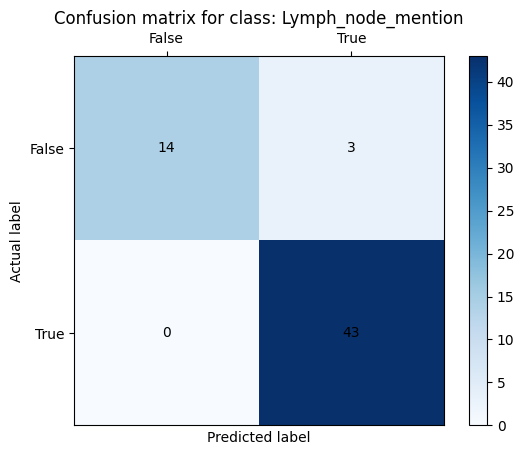

In [42]:
def create_confusion_matrix(df_pred, df_actual, columns):
    """
    Creates a confusion matrix for the given columns in two pandas dataframes.
    """
    # Combine the dataframes horizontally
    df_combined = pd.concat([df_pred[columns], df_actual[columns]], axis=1)

    
    # Create the confusion matrix
    cm = np.zeros((2, 2), dtype=np.int32)
    
    for i, val1 in enumerate([0,1]):
        for j, val2 in enumerate([0,1]):
            cm[i, j] = ((df_combined.iloc[:, 0] == val1) & (df_combined.iloc[:, 1] == val2)).sum()
    
    return cm


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Display the confusion matrix as an image
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Add a colorbar legend
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set the tick labels and axis labels
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(['False', 'True'])
    ax.set_yticklabels(['False', 'True'])
    ax.set_xlabel('Predicted label')
    ax.xaxis.tick_top()
    ax.set_ylabel('Actual label')

    # Loop over data dimensions and create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center', color='k')

    # Set the title
    ax.set_title(title)
    plt.show()
    
# Call the function to create the confusion matrix
cm = create_confusion_matrix(df_predicted, df_actual, column_compare)
plot_confusion_matrix(cm, title='Confusion matrix for class: {}'.format(column_compare))